In [1]:
import random
import string
import heapq
from collections import defaultdict
from tqdm import tqdm

def jaccard_distance(set1, set2):
    """Tính khoảng cách Jaccard = 1 - similarity"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0.0
    return 1 - intersection / union

class AgglomerativeClustering:
    def __init__(self, distance_threshold=0.3):
        self.distance_threshold = distance_threshold
        self.clusters = []
        self.clustroids = {}
        self.labels_ = []

    def _find_clustroid(self, cluster, data):
      if len(cluster) == 1:
          return cluster[0]
      best = None
      best_dist = float('inf')
      for i in cluster:
          distances = [jaccard_distance(data[i], data[j]) for j in cluster if i != j]
          if not distances:  # Nếu không có khoảng cách nào
              continue
          max_dist = max(distances)
          if max_dist < best_dist:
              best_dist = max_dist
              best = i
      return best if best is not None else cluster[0]

    def compute_diameter(self, cluster, data):
        if len(cluster) <= 1:
            return 0.0
        return max(
            jaccard_distance(data[i], data[j])
            for i in cluster for j in cluster if i != j
        )

    def fit(self, data):
        n_samples = len(data)
        self.clusters = [[i] for i in range(n_samples)]
        self.labels_ = [-1] * n_samples
        active = set(range(n_samples))

        # Heap chứa (distance, cluster_i, cluster_j)
        heap = []
        print("Tính toán khoảng cách ban đầu giữa các cặp...")
        for i in tqdm(range(n_samples)):
            for j in range(i + 1, n_samples):
                dists = [jaccard_distance(data[i], data[j])]
                dist = min(dists)
                heapq.heappush(heap, (dist, i, j))

        cluster_map = {i: i for i in range(n_samples)}  # ánh xạ ID cluster hiện tại
        iteration = 0

        while heap:
            dist, i, j = heapq.heappop(heap)
            if i not in active or j not in active:
                continue

            merged_cluster = self.clusters[i] + self.clusters[j]
            diameter = self.compute_diameter(merged_cluster, data)

            if diameter > self.distance_threshold:
                break  # Dừng khi cụm vượt quá ngưỡng đường kính

            print(f"\n[Iteration {iteration}] Merge cluster {i} and {j} | dist = {dist:.4f}, diam = {diameter:.4f}")
            self.clusters[i] = merged_cluster
            self.clusters[j] = []
            active.remove(j)

            # Cập nhật lại heap cho cluster i mới
            for k in active:
                if k == i:
                    continue
                dists = [
                    jaccard_distance(data[p1], data[p2])
                    for p1 in self.clusters[i]
                    for p2 in self.clusters[k]
                ]
                if not dists:
                    continue
                new_dist = min(dists)
                heapq.heappush(heap, (new_dist, i, k))

            iteration += 1

        # Loại cụm rỗng
        final_clusters = [c for c in self.clusters if c]
        self.clusters = final_clusters

        # Gán nhãn và tính clustroid
        for idx, cluster in enumerate(self.clusters):
            for i in cluster:
                self.labels_[i] = idx
            self.clustroids[idx] = self._find_clustroid(cluster, data)

        print("\nTổng số cụm:", len(self.clusters))
        for idx, c in enumerate(self.clusters):
            print(f"Cluster {idx}: size = {len(c)}, clustroid = {self.clustroids[idx]}")
        return self.clusters

    @staticmethod
    def generate_similar_dataset(n_samples=1000, n_bases=20, min_len=32, max_len=64, mutation_rate=0.03):
        def generate_shingle_pool(num_shingles=20, shingle_len=4):
            return [''.join(random.choices(string.ascii_lowercase, k=shingle_len)) for _ in range(num_shingles)]

        def generate_string_from_pool(length, pool):
            result = []
            while len(result) < length:
                result.append(random.choice(pool))
            return ''.join(result)[:length]

        def mutate_string(base, mutation_rate=0.05):
            chars = list(base)
            for i in range(len(chars)):
                if random.random() < mutation_rate:
                    chars[i] = random.choice(string.ascii_lowercase)
            return ''.join(chars)

        pool = generate_shingle_pool()
        base_strings = [generate_string_from_pool(random.randint(min_len, max_len), pool) for _ in range(n_bases)]

        data = []
        original_strings = []
        for _ in range(n_samples):
            base = random.choice(base_strings)
            mutated = mutate_string(base, mutation_rate)
            shingles = set(mutated[j:j+4] for j in range(len(mutated) - 3))
            data.append(shingles)
            original_strings.append(mutated)

        return original_strings, data


In [2]:
import matplotlib.pyplot as plt

def average_distances_to_clustroids(model, data):
    """Tính khoảng cách trung bình từ mỗi sample đến clustroid của cluster"""
    avg_distances = []
    for idx, cluster in enumerate(model.clusters):
        clustroid_idx = model.clustroids[idx]
        distances = [
            jaccard_distance(data[sample_idx], data[clustroid_idx])
            for sample_idx in cluster
        ]
        avg = sum(distances) / len(distances) if distances else 0
        avg_distances.append(avg)
    return avg_distances



In [6]:
import pandas as pd
def save_dataset_to_csv(strings, shingle_sets, filename="dataset.csv"):
    rows = []
    for idx, (s, sh_set) in enumerate(zip(strings, shingle_sets)):
        rows.append({
            "index": idx,
            "string": s,
            "shingles": '|'.join(sh_set)  # Dễ đọc hơn khi phân tích
        })
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"✅ Dataset saved to {filename}")


In [4]:
def plot_cluster_avg_distances(avg_distances):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(avg_distances)), avg_distances)
    plt.xlabel('Cluster index')
    plt.ylabel('Average Jaccard distance to clustroid')
    plt.title('Average distance to clustroid for each cluster')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [15]:
# === STEP 1: Generate similar dataset with both strings and shingles ===
strings, data = AgglomerativeClustering.generate_similar_dataset(
    n_samples=10000,
    n_bases=20,
    mutation_rate=0.01
)

save_dataset_to_csv(strings, data)




✅ Dataset saved to dataset.csv


Tính toán khoảng cách ban đầu giữa các cặp...


100%|██████████| 10000/10000 [04:25<00:00, 37.69it/s]



[Iteration 0] Merge cluster 1 and 11 | dist = 0.0000, diam = 0.0000

[Iteration 1] Merge cluster 1 and 15 | dist = 0.0000, diam = 0.0000

[Iteration 2] Merge cluster 1 and 19 | dist = 0.0000, diam = 0.0000

[Iteration 3] Merge cluster 1 and 36 | dist = 0.0000, diam = 0.0000

[Iteration 4] Merge cluster 1 and 59 | dist = 0.0000, diam = 0.0000

[Iteration 5] Merge cluster 1 and 113 | dist = 0.0000, diam = 0.0000

[Iteration 6] Merge cluster 1 and 115 | dist = 0.0000, diam = 0.0000

[Iteration 7] Merge cluster 1 and 168 | dist = 0.0000, diam = 0.0000

[Iteration 8] Merge cluster 1 and 187 | dist = 0.0000, diam = 0.0000

[Iteration 9] Merge cluster 1 and 191 | dist = 0.0000, diam = 0.0000

[Iteration 10] Merge cluster 1 and 222 | dist = 0.0000, diam = 0.0000

[Iteration 11] Merge cluster 1 and 251 | dist = 0.0000, diam = 0.0000

[Iteration 12] Merge cluster 1 and 308 | dist = 0.0000, diam = 0.0000

[Iteration 13] Merge cluster 1 and 341 | dist = 0.0000, diam = 0.0000

[Iteration 14] Merge

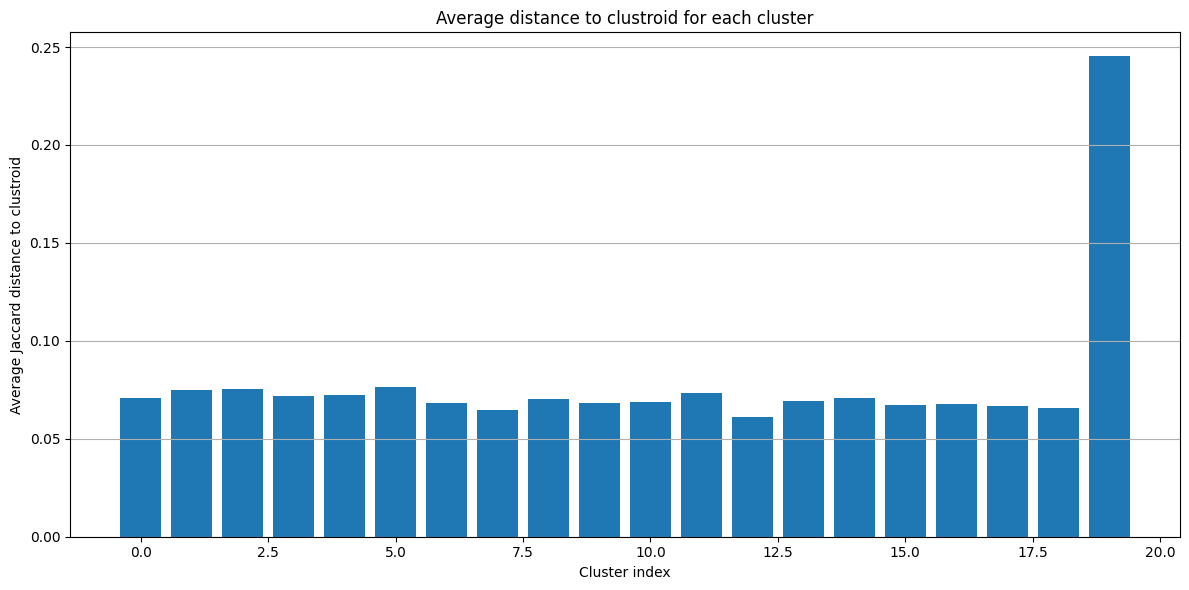

In [16]:


# Huấn luyện mô hình
model = AgglomerativeClustering(distance_threshold=0.9)
model.fit(data)

# Tính khoảng cách trung bình
avg_dists = average_distances_to_clustroids(model, data)

# Vẽ biểu đồ
plot_cluster_avg_distances(avg_dists)
